# PUSH approach
The PUSH approach put in system the job when it's created.

Cose devo studiare:
- Cercare di studiare un "giusto" Due Dates attraverso il plot del rooting di ogni pezzo
- cercare di capire se esiste un bootleneck e calcolare utilization rate 
- Individuare il WIP di questa metodologia 

In [1]:
from utils.seeds import Seeds
from env_system import ManufacturingSystem
from lib.server import Server
from collections.abc import Sequence
import random
import numpy as np
from scipy.stats import erlang
from tqdm import tqdm
import simpy
from utils.Analyze import analyze_mts
from utils.welch import Welch
from matplotlib import pyplot as plt


In [2]:
# define the Seed Class
sd = Seeds()

## Calculate service Distribution
We use the Erlang Distribution with this parametrization:
$$
\mu = scale * k + loc
$$
$$
\sigma^2 =  k * scale^2 
$$

For sampling we fix the shape value at 5 

In [3]:
# this lambda function has the feature of it's always has mean x and variance y
func=lambda x,y: erlang.rvs(5,loc=(x - 5 *(y/5)**(1/2)),scale=(y/5)**(1/2))

mean:20.0; var:0.2


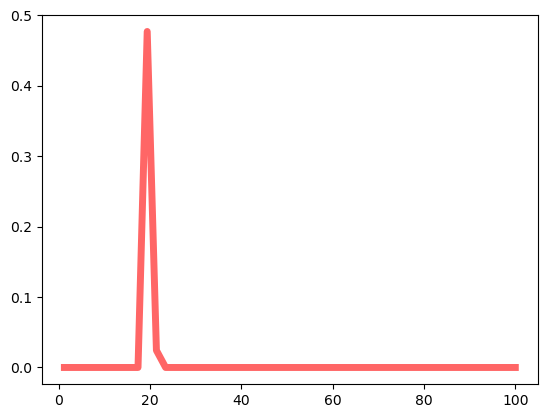

In [4]:
# mean 
x = 20
# var
y = 0.2
# shape
k = 5
scale =  (y/k)**(1/2)
loc = x - k * scale


mean,var= erlang.stats(k,loc=loc,scale=scale)

print(f'mean:{mean}; var:{var}')


x = np.linspace(erlang.ppf(0.01, k),
                100)
plt.plot(x, erlang.pdf(x, k,loc=loc,scale=scale),
       'r-', lw=5, alpha=0.6, label='gamma pdf')

# First Run

In [6]:
# replicate runs
TEST_EPISODES = 30
# SIM PARAMETERS
WARMUP_PERIOD= 114
MAX_WIP= 15
SIM_DURATION= 10000
RANDOM_SEED= 42
D_D_BOUND=(-2,2)
EVAL_DAYS= 180
WIP_TOLERANCE= 0.2
DAYS_LOOKBACK= 10
N_TRACKERS= 33
SIM_TIME_STEP = 1
VERBOSE= False


sim = ManufacturingSystem(
    inter_arrival_time_distribution=lambda: random.expovariate(lambd=1/5.1), # 0,25 order/day,
    service_time_distribution=lambda x,y: erlang.rvs(5,loc=(x - 5 *(y/5)**(1/2)),scale=(y/5)**(1/2)),
    rework_distribution=lambda: random.random() <= 0.2,
    due_dates_distribution=lambda : random.uniform(a=13,b=40),
    warmup_period=WARMUP_PERIOD,
    max_wip=MAX_WIP,
    sim_duration=SIM_DURATION,
    random_seed=RANDOM_SEED,
    eval_days=EVAL_DAYS,
    wip_tol=WIP_TOLERANCE,
    days_lookback=DAYS_LOOKBACK,
    n_trackers=N_TRACKERS,
    verbose=VERBOSE,
    d_d_bound=D_D_BOUND,
    sim_time_step=SIM_TIME_STEP,
    push_model=True
)

number of job create: 1923
number of job done: 1916
number of rework: 236
Average Product Inter-arrival time = 5.20 days


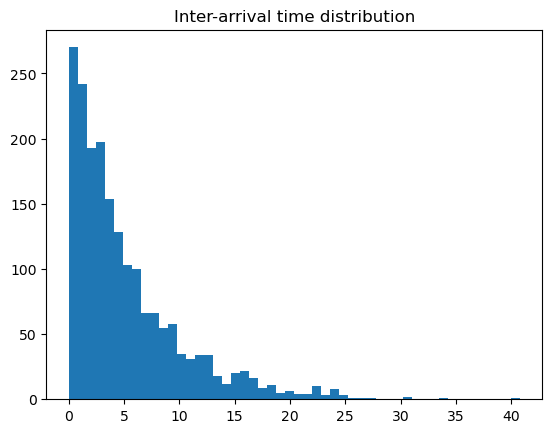

In [7]:
print(f'number of job create: {len(sim.jobs)}')
print(f'number of job done: {sim.finished_jobs}')
print(f'number of rework: {sim.machines_list[6].n_rework}')
sim.plot_average_inter_arrival_time()

Average Product Time in System  = 106.83 days


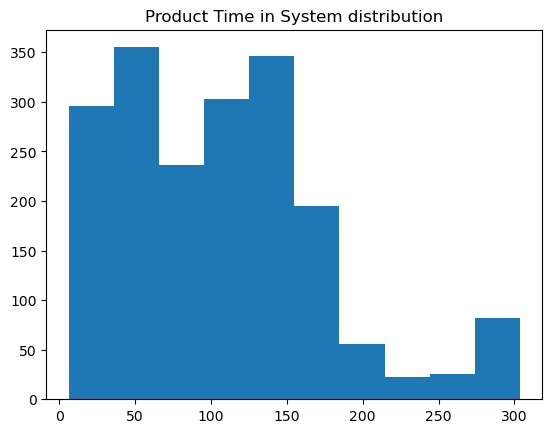

In [8]:
sim.plot_products_time_in_system()

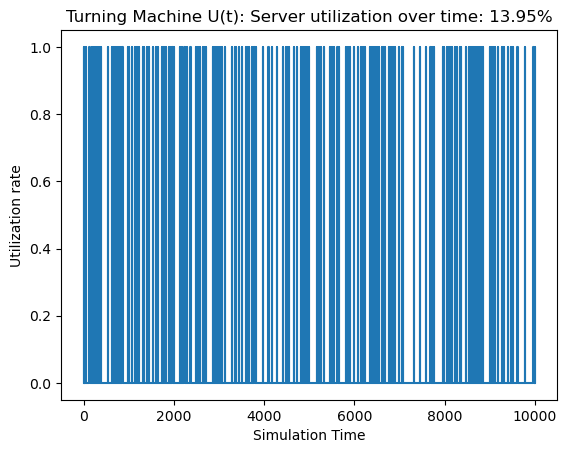

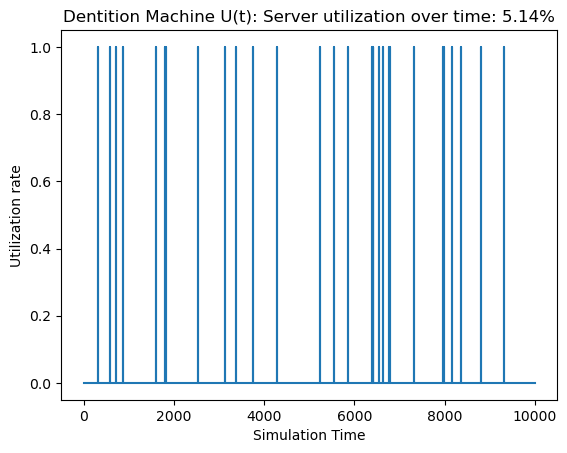

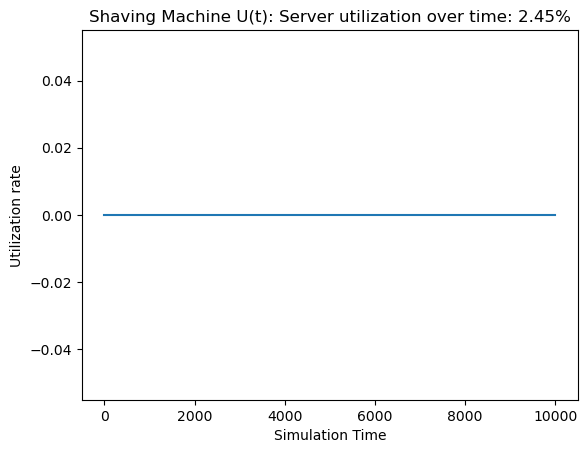

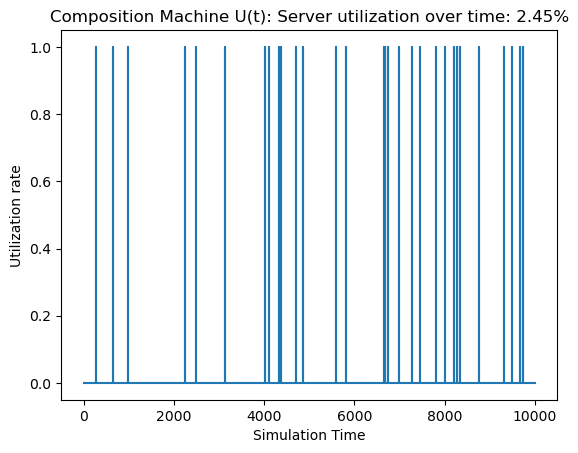

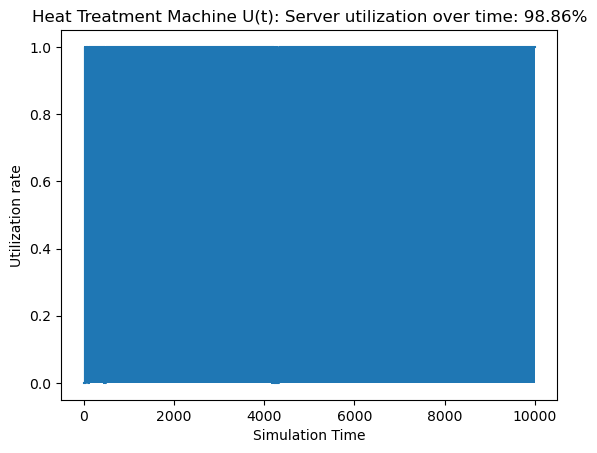

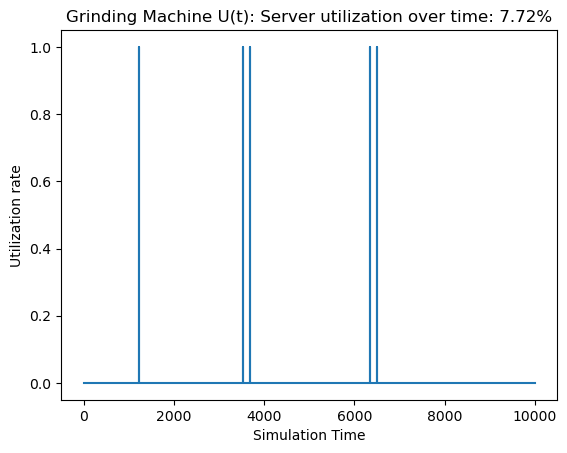

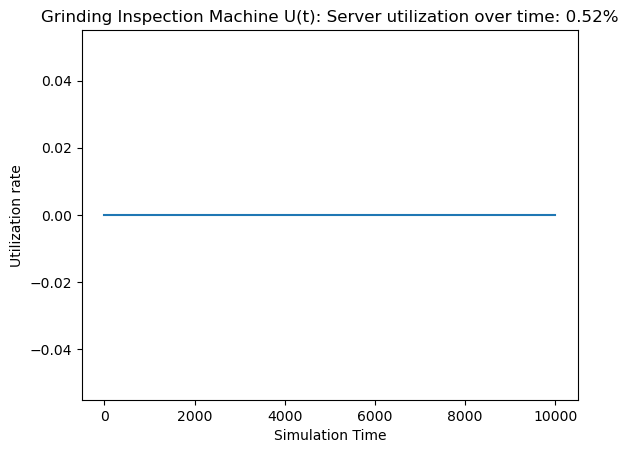

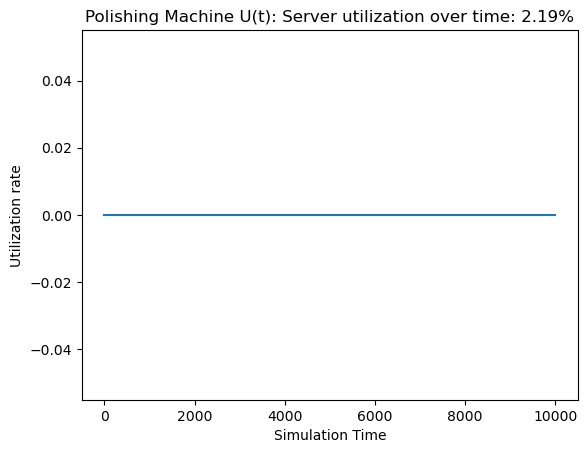

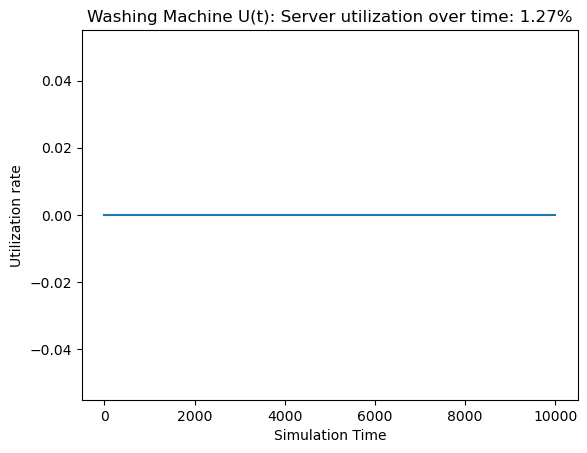

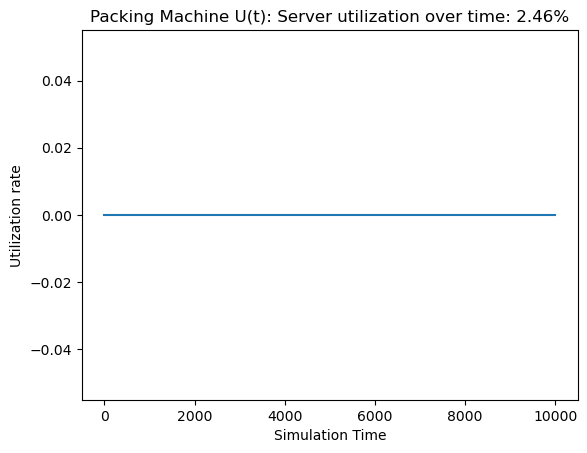

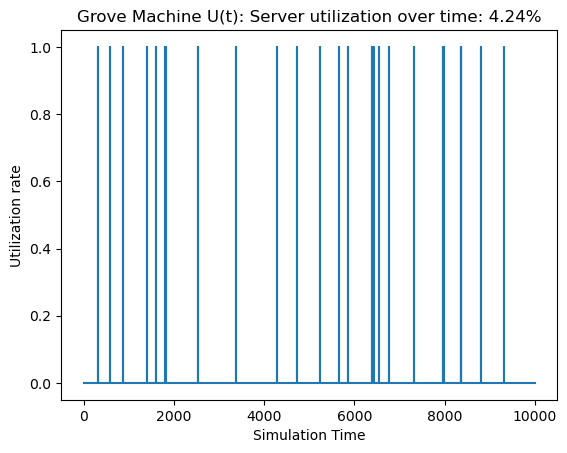

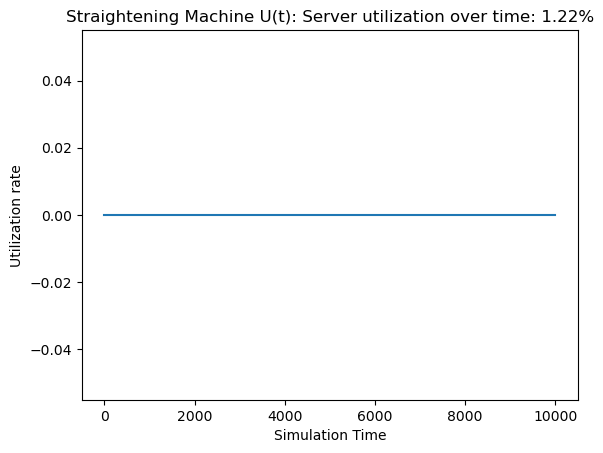

In [9]:
for machine in sim.machines_list:
    machine.plot_ut()

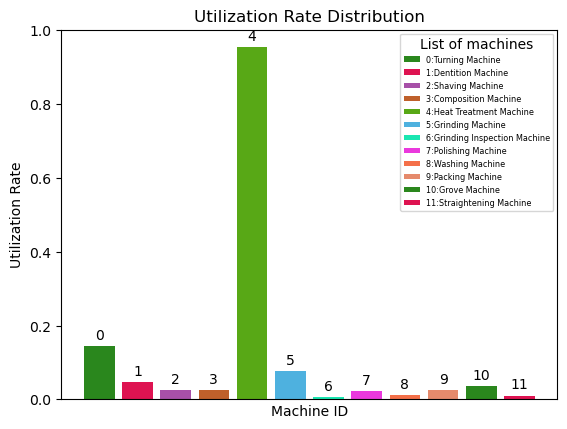

In [9]:
sim.plot_ut_rate_in_system()

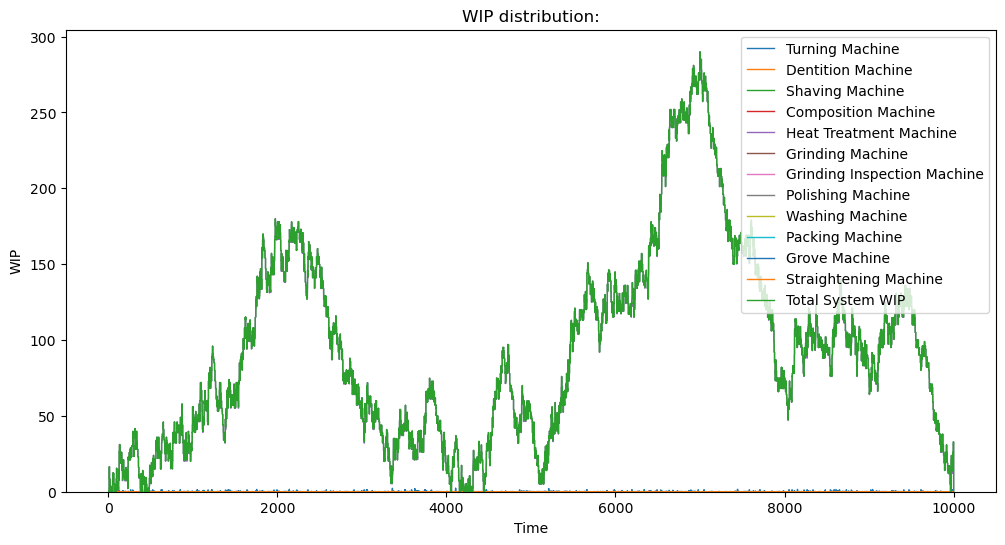

In [10]:
sim.plot_wip_in_system()

In [11]:
# import numpy as np
# job_in_sys = np.fromiter(manufacturing_sys.product_time_in_system, dtype=float)
# idx = np.argmax(job_in_sys)
# job = [job for  job in manufacturing_sys.jobs if job.done][idx]
# job.delays

# Calculate the D.D.

In [11]:
N_RUNS = 50 # number of runs 
M_RUNS = N_RUNS + 100


In [12]:
def run_system(seed: int | None, until: float = 5000) -> ManufacturingSystem:
    
    sim = ManufacturingSystem(
    inter_arrival_time_distribution=lambda: random.expovariate(lambd=1/5.3), # 0,25 order/day,
    service_time_distribution=lambda x,y: erlang.rvs(5,loc=(x - 5 *(y/5)**(1/2)),scale=(y/5)**(1/2)),
    rework_distribution=lambda: random.random() <= 0.2,
    due_dates_distribution=lambda : random.uniform(a=13,b=40),
    warmup_period=WARMUP_PERIOD,
    max_wip=MAX_WIP,
    sim_duration=SIM_DURATION,
    random_seed=seed,
    eval_days=EVAL_DAYS,
    wip_tol=WIP_TOLERANCE,
    days_lookback=DAYS_LOOKBACK,
    n_trackers=N_TRACKERS,
    verbose=VERBOSE,
    d_d_bound=D_D_BOUND,
    sim_time_step=SIM_TIME_STEP,
    push_model=True
)
    return sim


def main_system(*seeds: int, until: int=5000):
    runs = []
    for seed in tqdm(seeds):
        run_i = run_system(seed, until=until)
        runs.append(run_i)

    return runs

In [13]:

sys_runs = main_system(*sd.get_seeds(N_RUNS))

100%|██████████| 50/50 [03:10<00:00,  3.81s/it]


In [1]:
means = []
sys_runs[0].mts_stats[0] = [0,0,0]
for list_a in  sys_runs[0].mts_stats:
    means.append(np.mean(list_a))
means

NameError: name 'sys_runs' is not defined

Text(0.5, 1.0, '50 runs Mean time in System distribution')

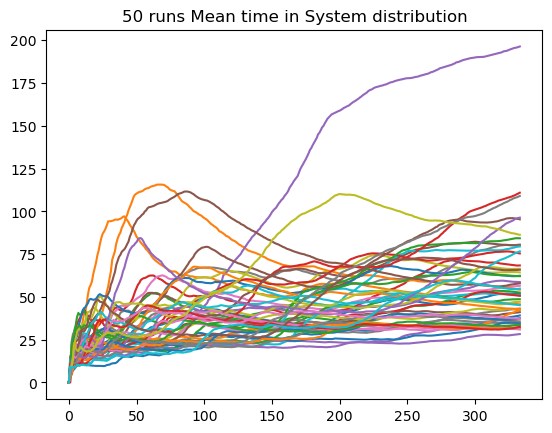

In [14]:
means_tot = []
for run in sys_runs:
    means = []
    for list_a in run.mts_stats:
        means.append(np.mean(list_a))
                
    means_tot.append(means)    

sys_arr = np.asarray(means_tot)
plt.plot(sys_arr.T)
plt.title(f"{N_RUNS} runs Mean time in System distribution")

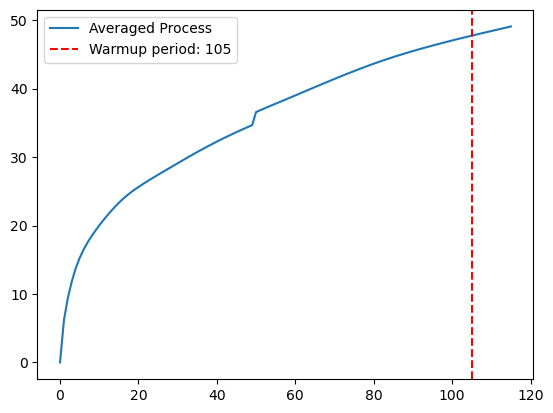

In [20]:

welch = Welch(sys_arr,window_size=50, tol=0.2)
welch.plot()

In [15]:

sys_runs = main_system(*sd.get_interval_seeds(N_RUNS,M_RUNS))

alpha = 0.05

mts_sample_mean_A, mts_sample_variance_A, half_interval_A = analyze_mts(sys_runs, warmup_period=114, alpha=alpha)

print(f"MTS Sample Mean: {mts_sample_mean_A:.2f}")
print(f"MTS Sample Variance: {mts_sample_variance_A:.2f}")
print(f"Half Interval: {half_interval_A:.2f}")
print(f"Confidence Interval [{alpha=}]: ({mts_sample_mean_A - half_interval_A:.2f}, {mts_sample_mean_A + half_interval_A:.2f})")
print(f"Relative Error: {100 * half_interval_A / mts_sample_mean_A:.2f}%")

100%|██████████| 100/100 [06:23<00:00,  3.83s/it]


MTS Sample Mean: 57.56
MTS Sample Variance: 698.55
Half Interval: 4.39
Confidence Interval [alpha=0.05]: (53.17, 61.95)
Relative Error: 7.62%


100%|██████████| 100/100 [06:22<00:00,  3.82s/it]


Text(0.5, 1.0, '100 runs Total WIP in System distribution')

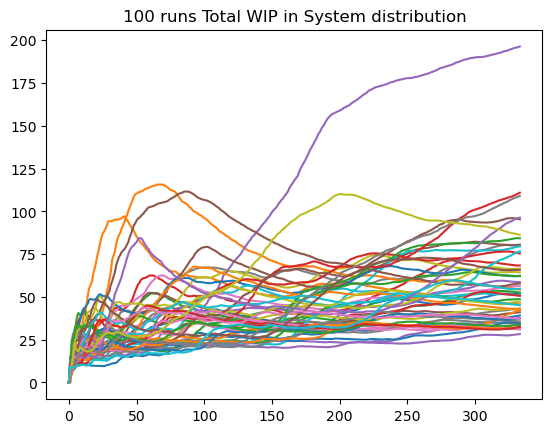

In [16]:
import statistics

sys_runs = main_system(*sd.get_interval_seeds(N_RUNS,M_RUNS))

sample = [
        statistics.mean(run.wip_tot_stats)
        for run in sys_runs
    ]
sys_arr = np.asarray(means_tot)
plt.plot(sys_arr.T)
plt.title(f"{M_RUNS -N_RUNS} runs Total WIP in System distribution")

In [18]:
from project.utils.Analyze import analyze_wip

alpha = 0.05

mts_sample_mean_A, mts_sample_variance_A, half_interval_A = analyze_wip(sys_runs, warmup_period=114, alpha=alpha)

print(f"MT WIP Mean: {mts_sample_mean_A:.2f}")
print(f"MT WIP Sample Variance: {mts_sample_variance_A:.2f}")
print(f"Half Interval: {half_interval_A:.2f}")
print(f"Confidence Interval [{alpha=}]: ({mts_sample_mean_A - half_interval_A:.2f}, {mts_sample_mean_A + half_interval_A:.2f})")
print(f"Relative Error: {100 * half_interval_A / mts_sample_mean_A:.2f}%")

MT WIP Mean: 49.99
MT WIP Sample Variance: 738.38
Half Interval: 4.51
Confidence Interval [alpha=0.05]: (45.48, 54.50)
Relative Error: 9.03%


In [22]:
sys_runs[0].ea_ta_ti_stats[-1]

[602, 1215, 85]